In [41]:
# Run this cell before anything else to import the packages you are allowed to used for this assignment

import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import sys
from io import StringIO
import statsmodels.api as sm
import datetime 

from numpy.testing import assert_equal, assert_almost_equal
from pandas.testing import assert_frame_equal

pd.options.display.max_rows = 20

In [42]:
df = pd.read_csv('etsy_04-03_Top10000 v2.csv', header = 0,encoding= 'unicode_escape')
df.head()
# for col in df.columns:
#      print(col)
# print(df) #10,000 rows

,shop_id,shop_name,url,shop_create_date,shop_update_date,digital_listing_count,digital_delivery_listing_count,is_open,seller_name,sold_count,...,primary_language_id,accepts_direct_checkout,accepts_paypal,ships_to_country_ids,display_name,is_eligible_free_shipping,has_min_free_shipping,has_free_shipping,ships_to_regions,RunDate
0,9811209,PlannerKate1,https://www.etsy.com/shop/PlannerKate1,1406655490,1649003016,0,0,True,Kate Antesberger,1839198,...,0,True,False,"[209, 0, 150, 79, 175]",Kate,False,False,False,['ANY'],4/3/2022 12:05
1,10204022,CaitlynMinimalist,https://www.etsy.com/shop/CaitlynMinimalist,1414883299,1649004834,0,0,True,Kate Kim,1565708,...,0,True,False,"[79, 167, 290, 284, 209, 61, 58, 74, 105, 55, ...",Kate,True,False,True,['ANY'],4/3/2022 12:05
2,9901413,Beadboat1,https://www.etsy.com/shop/Beadboat1,1408476670,1649003805,0,0,True,Katy,1461640,...,0,True,False,"[70, 118, 146, 90, 151, 79, 207, 91, 71, 215, ...",Katy,True,True,True,"['AL', 'AM', 'AU', 'AT', 'BE', 'BG', 'BY', 'BR...",4/3/2022 12:05
3,8617622,ModParty,https://www.etsy.com/shop/ModParty,1380209741,1649001097,1,0,True,ModParty,1285848,...,0,True,False,"[175, 61, 80, 220, 219, 204, 56, 103, 79, 128,...",ModParty,False,False,False,['US'],4/3/2022 12:05
4,5413707,yakutum,https://www.etsy.com/shop/yakutum,1283548057,1648988418,0,0,True,yakutum,969314,...,0,True,True,"[209, 167, 127, 0, 203, 61, 131]",yakutum,False,False,False,['ANY'],4/3/2022 12:05


# 1) Data cleaning

In [43]:
# if error in this cell -> rerun from first cell
# data prep: remove unnecessary columns

  # drop columns that we do not want to examine
df.drop('url', axis=1, inplace=True)
df.drop('shop_name', axis=1, inplace=True)
df.drop('ships_to_country_ids', axis=1, inplace=True) #included in ships_to_regions & not in line with the etsy url

df.groupby('geoname_id').size() #3413 unique values, remove??

 # drop columns that have same value in all rows or each row have different values
df.groupby('shop_id').size().sort_values() #
df.groupby('shop_create_date').size().sort_values() #
df.groupby('shop_update_date').size().sort_values() #
df.groupby('digital_listing_count').size().sort_values()
df.groupby('is_open').size().sort_values() #10,000 open --> remove is_open column
df.groupby('seller_name').size().sort_values() #8357 --> do not remove seller_name
df.groupby('sold_count').size().sort_values()
df.groupby('additional_customization').size().sort_values() #5143 false, 4857 true
df.groupby('active_listing_count').size().sort_values()
df.groupby('status').size().sort_values() #10,000 active --> remove status column
print(df.groupby('location').size().sort_values()) #3376 unique values, all different, countries also in country_code --> remove location column
print(df.groupby('city').size().sort_values()) #1810 unique values
print(df.groupby('region').size().sort_values()) #449 unique values
df.groupby('name').size().sort_values() #10,000 unique values --> remove name column
df.groupby('headline').size().sort_values() #9437 unique values
df.groupby('favorites_count').size().sort_values() #7208 unique values
df.groupby('average_rating').size().sort_values() #2696 unique values
df.groupby('total_rating_count').size().sort_values() #7130 unique values
df.groupby('average_rating_count').size().sort_values() #4060 unique values
print(df.groupby('geoname_id').size().sort_values()) #3413 unique values, of which 1282 are 0
df.groupby('country_code').size().sort_values() #82 unique values
df.groupby('currency_code').size().sort_values() #18 unique values
df.groupby('has_currency_code').size().sort_values() #10,000 true --> remove has_currency_code column
df.groupby('primary_language_id').size().sort_values() #9 unique values
df.groupby('accepts_direct_checkout').size().sort_values() #569 false, 9431 true
df.groupby('accepts_paypal').size().sort_values() #9366 false, 634 true
df.groupby('display_name').size().sort_values() #5783 unique values
df.groupby('is_eligible_free_shipping').size().sort_values() #3255 false, 5299 true
df.groupby('has_min_free_shipping').size().sort_values() #5351 false, 3203 true
df.groupby('has_free_shipping').size().sort_values() #3255 false, 5299 true
df.groupby('ships_to_regions').size().sort_values() # ??? still need to separate per country
df.groupby('RunDate').size() #10,000 4/3/2022 12:05 --> RunDate column should be removed but still needed (removed later)

df.drop('is_open', axis=1, inplace=True)
df.drop('status', axis=1, inplace=True)
df.drop('city', axis=1, inplace=True)
df.drop('region', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('has_currency_code', axis=1, inplace=True)

location
??guilas, Spain              1
Nauvoo, Illinois             1
Navarre, Florida             1
Nazareth, Pennsylvania       1
Nederland, Colorado          1
                          ... 
Houston, Texas              94
London, United Kingdom     125
United States              129
New York, United States    176
LA, California             279
Length: 3376, dtype: int64
city
zhejiang          1
Pacific Beach     1
Oxnard            1
Oxley             1
Owosso            1
                 ..
Austin           11
Portland         11
Vancouver        14
San Diego        16
Los Angeles      17
Length: 1810, dtype: int64
region
--              1
Sichuan         1
Shropshire      1
Shandong        1
Seoul           1
             ... 
IL             69
WA             70
TX             72
FL             77
CA            249
Length: 449, dtype: int64
geoname_id
4707814       1
4960358       1
4961898       1
4962589       1
4963312       1
           ... 
5128581     125
2643743     125
6

In [44]:
# data preparation: check which columns have empty cells
  ## drop columns with much missing values
print(len(df.columns))
print(df["shop_id"].isna().sum())
print(df["shop_update_date"].isna().sum())
print(df["digital_listing_count"].isna().sum())
print(df["digital_delivery_listing_count"].isna().sum())
print(df["seller_name"].isna().sum())
print(df["sold_count"].isna().sum())
print(df["additional_customization"].isna().sum())
print(df["active_listing_count"].isna().sum())
print(df["location"].isna().sum()) #1292 missing values
#print(df["city"].isna().sum()) #7397 missing values --> drop city column
#print(df["region"].isna().sum()) #7430 missing values--> remove region column (vague) & also in countrycode
print(df["headline"].isna().sum()) #494 missing values & not so interesting --> drop headline column
print(df["favorites_count"].isna().sum())
print(df["average_rating"].isna().sum()) #7 missing values --> replace NaN values with mean
print(df["total_rating_count"].isna().sum())
print(df["geoname_id"].isna().sum()) #0 missing values, but 1282 0 values
print(df["country_code"].isna().sum()) #973 missing values
print(df["currency_code"].isna().sum())
print(df["primary_language_id"].isna().sum())
print(df["accepts_direct_checkout"].isna().sum())
print(df["accepts_paypal"].isna().sum())
print(df["is_eligible_free_shipping"].isna().sum()) #1446 missing values --> remove NaN
print(df["has_min_free_shipping"].isna().sum()) #1446 missing values --> remove NaN
print(df["has_free_shipping"].isna().sum()) #1446 missing values --> remove NaN
print(df["ships_to_regions"].isna().sum()) #1446 missing values --> remoe NaN

# replace numeric NaN with mean
average_rating_mean = df['average_rating'].mean()
df['average_rating'] = df['average_rating'].fillna(average_rating_mean)
#print(df["average_rating"].isna().sum())

## remove NaN rows from average_rating, is_eligible_free_shipping, has_min_free_shipping, has_free_shipping, ships_to_regions
df = df[df['average_rating'].notna()]
df = df[df['is_eligible_free_shipping'].notna()]
df = df[df['has_min_free_shipping'].notna()]
df = df[df['has_free_shipping'].notna()]
df = df[df['ships_to_regions'].notna()]
#df = df[df['city'].notna()]
df = df[df['location'].notna()]
#df = df[df['region'].notna()]
df= df[df['geoname_id'] != 0] # using this line instead of location results in 7527 rows which is not much better --> remove geoname column


## remove headline, city columns
df.drop('headline', axis=1, inplace=True)

newdf = df.copy()

for col in newdf.columns:
     print(col)



27
0
0
0
0
0
0
0
0
1292
494
0
7
0
0
973
0
0
0
0
1446
1446
1446
1446
shop_id
shop_create_date
shop_update_date
digital_listing_count
digital_delivery_listing_count
seller_name
sold_count
additional_customization
active_listing_count
location
favorites_count
average_rating
total_rating_count
average_rating_count
geoname_id
country_code
currency_code
primary_language_id
accepts_direct_checkout
accepts_paypal
display_name
is_eligible_free_shipping
has_min_free_shipping
has_free_shipping
ships_to_regions
RunDate


In [45]:
## transform booleans to binary values
newdf = newdf.replace(True,1)
newdf = newdf.replace("TRUE",1)
newdf = newdf.replace(False,0)
newdf = newdf.replace("FALSE",0)

## transform shop_create_date, shop_update_date form unix epoch time to dateTime
newdf['shop_create_date'] = pd.to_datetime(newdf['shop_create_date'],unit='s')
newdf['shop_update_date'] = pd.to_datetime(newdf['shop_update_date'],unit='s')

## add Time since creation && Average daily sales
newdf['RunDate'] = pd.to_datetime(newdf['RunDate'])
newdf['time_since_creation'] = newdf['RunDate'] - newdf['shop_create_date']
newdf['days_since_creation'] = newdf['time_since_creation'].dt.days

newdf['average_daily_sales'] = newdf['sold_count']/ newdf['days_since_creation']
newdf.drop('time_since_creation', axis=1, inplace=True)
newdf.drop('RunDate', axis=1, inplace=True)

newdf.head()

,shop_id,shop_create_date,shop_update_date,digital_listing_count,digital_delivery_listing_count,seller_name,sold_count,additional_customization,active_listing_count,location,...,primary_language_id,accepts_direct_checkout,accepts_paypal,display_name,is_eligible_free_shipping,has_min_free_shipping,has_free_shipping,ships_to_regions,days_since_creation,average_daily_sales
0,9811209,2014-07-29 17:38:10,2022-04-03 16:23:36,0,0,Kate Antesberger,1839198,1,2583,"Oak Harbor, Ohio",...,0,1,0,Kate,0,0,0,['ANY'],2804,655.919401
1,10204022,2014-11-01 23:08:19,2022-04-03 16:53:54,0,0,Kate Kim,1565708,1,1070,"LA, California",...,0,1,0,Kate,1,0,1,['ANY'],2709,577.965301
2,9901413,2014-08-19 19:31:10,2022-04-03 16:36:45,0,0,Katy,1461640,1,8511,"Dallas, Texas",...,0,1,0,Katy,1,1,1,"['AL', 'AM', 'AU', 'AT', 'BE', 'BG', 'BY', 'BR...",2783,525.203018
3,8617622,2013-09-26 15:35:41,2022-04-03 15:51:37,1,0,ModParty,1285848,1,1618,"Tustin, California",...,0,1,0,ModParty,0,0,0,['US'],3110,413.455949
4,5413707,2010-09-03 21:07:37,2022-04-03 12:20:18,0,0,yakutum,969314,1,24293,"Istanbul, Turkey",...,0,1,1,yakutum,0,0,0,['ANY'],4229,229.206432


# 2) Descriptive Analysis (+cleaning)

### Data types columns
##### Qualitative columns: 
shop_id
shop_create_date
shop_update_date
seller_name
location
region
geoname_id
country_code
currency_code
primary_language_id
ships_to_country_ids
display_name
ships_to_regions
days_since_creation
average_daily_sales

##### Booleans:
additional_customization
accepts_direct_checkout
accepts_paypal
is_eligible_free_shipping
has_min_free_shipping
has_free_shipping

##### Quantitative columns:
digital_listing_count
digital_delivery_listing_count
sold_count
active_listing_count
favorites_count
average_rating
total_rating_count
average_rating_count

## Quantitative analysis

In [46]:
# find basic statistics from data
quant_cols = ["digital_listing_count","digital_delivery_listing_count","sold_count","active_listing_count","favorites_count","average_rating","total_rating_count","days_since_creation","average_daily_sales"]
#print(newdf[quant_cols].describe(), end = "\n")

## maybe also put in bins
# plot histograms
# newdf.hist(column="digital_listing_count")
# newdf.hist(column="digital_delivery_listing_count")
# newdf.hist(column="sold_count")
# newdf.hist(column="active_listing_count")
# newdf.hist(column="favorites_count")
# newdf.hist(column="average_rating")
# newdf.hist(column="total_rating_count")
# newdf.hist(column="average_rating_count")
# newdf.hist(column="days_since_creation")
# newdf.hist(column="average_daily_sales")

# add some other plots
# newdf.boxplot(column="digital_listing_count")
# newdf.boxplot(column="digital_delivery_listing_count")
# newdf.boxplot(column="sold_count")
# newdf.boxplot(column="active_listing_count")
# newdf.boxplot(column="favorites_count")
# newdf.boxplot(column="average_rating")
# newdf.boxplot(column="total_rating_count")
# newdf.boxplot(column="average_rating_count")
# newdf.boxplot(column="days_since_creation")
# newdf.boxplot(column="average_daily_sales")

# remove outliers from data using IQR from https://www.codegrepper.com/code-examples/python/z+score+python+remove+outliers
## removed 5000 data rows --> too much?
Q1 = newdf[quant_cols].quantile(0.25)
Q3 = newdf[quant_cols].quantile(0.75)
IQR = Q3 - Q1

newdf2 = newdf[~((newdf[quant_cols] < (Q1 - 1.5 * IQR)) |(newdf[quant_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(newdf2[quant_cols].describe(), end = "\n")

       digital_listing_count  digital_delivery_listing_count     sold_count  \
count            4141.000000                          4141.0    4141.000000   
mean                0.049022                             0.0   38820.238831   
std                 0.267864                             0.0   15647.444280   
min                 0.000000                             0.0   22730.000000   
25%                 0.000000                             0.0   27196.000000   
50%                 0.000000                             0.0   33512.000000   
75%                 0.000000                             0.0   45522.000000   
max                 2.000000                             0.0  100319.000000   

       active_listing_count  favorites_count  average_rating  \
count           4141.000000      4141.000000     4141.000000   
mean             487.172181      5700.234484        4.915002   
std              442.597641      4343.451579        0.055979   
min                2.000000     

## Qualitative analysis

In [47]:
## could also do this for each column in a separate cell
#print(newdf2)
#shop_id
#shop_create_date
#shop_update_date
#RunDate


# examine dates
earliest_create_date = newdf2["shop_create_date"].min()
latest_create_date = newdf2["shop_create_date"].max()
earliest_update_date = newdf2["shop_update_date"].min()
latest_update_date = newdf2["shop_update_date"].max()

print(earliest_create_date,latest_create_date,earliest_update_date,latest_update_date)

# examine other variables
newdf2["seller_name"].value_counts()
newdf2["location"].value_counts()
newdf2["region"].value_counts()
newdf2["geoname_id"].value_counts()
newdf2["country_code"].value_counts()
newdf2["currency_code"].value_counts()
newdf2["primary_language_id"].value_counts()
newdf2["display_name"].value_counts()
newdf2["ships_to_regions"].value_counts()
newdf2["is_eligible_free_shipping"].value_counts()
newdf2["has_min_free_shipping"].value_counts()
newdf2["additional_customization"].value_counts()
newdf2["accepts_direct_checkout"].value_counts()
newdf2["accepts_paypal"].value_counts()
newdf2["is_eligible_free_shipping"].value_counts()
newdf2["has_min_free_shipping"].value_counts()
newdf2["has_free_shipping"].value_counts()

## could also add bar chart by using .plot(kind="bar")
## qq plots etc

2010-09-03 20:27:53 2021-01-25 14:59:05 2020-07-20 20:12:25 2022-04-04 23:52:22


KeyError: 'region'

array([[<AxesSubplot:title={'center':'shop_create_date'}>]], dtype=object)

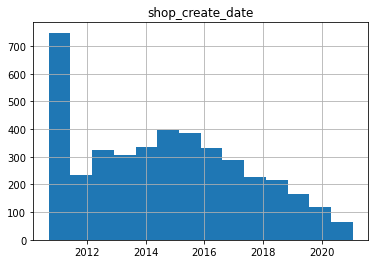

In [8]:
# in what period are most shops created? --> https://barkingdata.com/?etsy-new-shops-trend/
newdf2.hist(column="shop_create_date", bins = 14)

In [9]:
# shops in which countries have the most sales?
country_sales_df = newdf2.groupby('country_code')['sold_count'].sum().sort_values()
print(country_sales_df)

# shops in which countries have the most average daily sales?
country_average_daily_sales_df = newdf2.groupby('country_code')['average_daily_sales'].sum().sort_values()
print(country_average_daily_sales_df)

country_code
MT        22744
BE        26418
MA        26628
SG        27346
SE        28133
        ...    
CN      2465525
DE      2750245
CA      6221918
GB     17944700
US    110331730
Name: sold_count, Length: 44, dtype: int64
country_code
BE        6.248344
SG        6.895108
MT        7.746594
CY       12.325127
HU       13.154653
          ...     
CN     1240.064781
DE     1655.208514
CA     2944.573971
GB     9496.149102
US    46538.298051
Name: average_daily_sales, Length: 44, dtype: float64


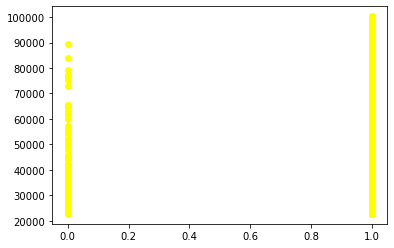

PointbiserialrResult(correlation=-0.0033877158030329573, pvalue=0.8274786950315862)

In [33]:
# is there a correlation between direct checkout + number of sales?
#newdf2.plot.scatter(x = 'accepts_direct_checkout', y = 'sold_count', s = 100);
df = newdf2
x = df["accepts_direct_checkout"]
y = df["sold_count"]
plt.scatter(x, y, c = 'yellow')
plt.show()
stats.pointbiserialr(x, y)
#So corr of correlation = -0.0033877158030329573 and pvalue = 0.8274786950315862, small chance of co

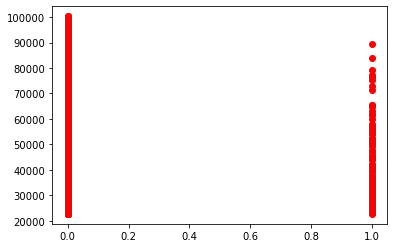

PointbiserialrResult(correlation=-0.0012004963012795349, pvalue=0.9384410814758184)

In [38]:
# is there a correlation between paypal + number of sales
x = df["accepts_paypal"]
y = df["sold_count"]
plt.scatter(x, y, c = 'red')
plt.show()
stats.pointbiserialr(x, y)
#So corr of correlation = -0.0012004963012795349 and pvalue = 0.9384410814758184, small chance of corr

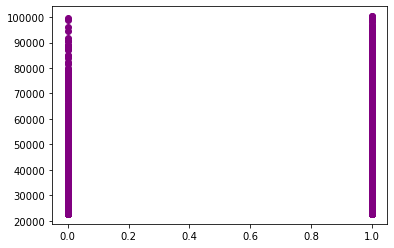

PointbiserialrResult(correlation=0.05972673323421584, pvalue=0.00012019687932381603)

In [37]:
# is there a correlation between free shipping + number of sales?
x = df["has_free_shipping"]
y = df["sold_count"]
plt.scatter(x, y, c = 'purple')
plt.show()
stats.pointbiserialr(x, y)
#So corr of correlation = 0.05972673323421584 and pvalue = 0.00012019687932381603, high chance of corr

In [35]:
# is there a correlation between  number of countries to ship to and the number of sales of a shop
## add "number_of_shipping_countries" column from "ships_to_country_ids" column

x = df["ships_to_country_ids"]
y = df["sold_count"]
plt.scatter(x, y, c = 'blue')
plt.show()
stats.pointbiserialr(x, y)

KeyError: 'ships_to_country_ids'

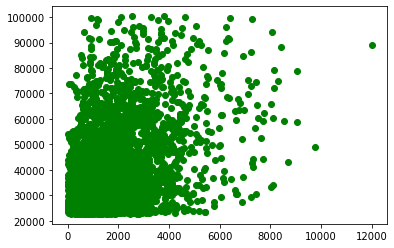

PointbiserialrResult(correlation=0.3928742635482887, pvalue=6.599300908570612e-153)

In [36]:
# is there a correlation between the average rating and the number of sales
x = df["average_rating_count"]
y = df["sold_count"]
plt.scatter(x, y, c = 'green')
plt.show()
stats.pearsonr(x, y)
stats.pointbiserialr(x, y)
#So corr of correlation=0.3928742635482887 and pvalue=6.599300908570612e-153, high chance of corr

# Hypothesis testing

# Prediction models

In [ ]:
# check for assumptions!!